In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def OsyczkaKundu(x):
    f1 = -25*(x[0]-2.0)**2 - (x[1]-2.0)**2 - (x[2]-1.0)**2 - (x[3]-4)**2 - (x[4]-1.0)**2
    f2 = np.sum(x**2)
    return np.array([f1,f2])

def constraints(x):
    c1 = x[0]+x[1]-2.0
    c2 = 6.0 - x[0] - x[1]
    c3 = 2.0 - x[1] + x[0]
    c4 = 2.0 - x[0] + 3.0*x[1]
    c5 = 4.0 - (x[2]-3.0)**2 - x[3]
    c6 = (x[4]-3)**2 + x[5] - 4.0
    return np.array([c1,c2,c3,c4,c5,c6])

In [3]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (  0.0,10.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (  0.0,10.0)},
        {'name': 'var_3', 'type': 'continuous', 'domain': (  1.0, 5.0)},
        {'name': 'var_4', 'type': 'continuous', 'domain': (  1.0, 6.0)},
        {'name': 'var_5', 'type': 'continuous', 'domain': (  0.0, 5.0)},
        {'name': 'var_6', 'type': 'continuous', 'domain': (  0.0,10.0)}]

space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c3 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c4 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c5 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c6 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1,model_c2,model_c3,model_c4,model_c5,model_c6]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 150
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))
C_init = np.zeros((X_init.shape[0],6))

for i in range(num_init):
    Y_init[i,:] = OsyczkaKundu(X_init[i,:])
    C_init[i,:] = constraints(X_init[i,:])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init,C_init)))

[[ 2.7     6.6333  1.3067 ... 19.2    -1.484   1.9669]
 [ 2.6333  5.8333  1.7067 ... 16.8667 -0.456  -2.1442]
 [ 0.7667  3.0333  4.72   ... 10.3333 -2.3751  1.5403]
 ...
 [ 0.6333  9.1667  1.2533 ... 28.8667 -2.3675 11.2336]
 [ 4.1667  5.1     2.2933 ... 13.1333 -0.616   8.7803]
 [ 5.4333  0.7     1.7867 ... -1.3333 -2.6555  7.0558]]


In [4]:
C_clip = np.copy(C_init)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_init[C_clip==0.0,:])
print(Pareto)

[[-94.0163  73.0374]
 [-17.885   51.4928]]


In [6]:
iter_count = 350-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    C_clip = np.copy(C_step)
    C_clip[C_clip > 0] = 0.0
    C_clip = np.sum(C_clip**2,axis=1)
    
    Pareto = ParetoFront(Y_step[C_clip==0.0,:])
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,jitter_c = np.array([0.0,0.0,0.0,0.0,0.0,0.0]),
                                  P=Pareto,r=np.array([0,80]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                                        model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = OsyczkaKundu(x_next[0])
    c_next =  constraints(x_next[0])
    print("Current iteration - ",current_iter," : ",np.hstack((x_next[0],y_next,c_next)))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

(2, 2)
Current iteration -  0  :  [  2.3474   0.7496   4.5458   1.3197   4.7288   4.6191 -38.2411  72.175
   1.097    2.903    3.5978   1.9014   0.2908   3.6077]
(3, 2)
Current iteration -  1  :  [ 1.6659e+00  3.4511e-01  3.1389e+00  1.0693e+00  1.8276e-01  5.1331e-01
 -1.9361e+01  1.4188e+01  1.1034e-02  3.9890e+00  3.3208e+00  1.3694e+00
  2.9114e+00  4.4501e+00]
(3, 2)
Current iteration -  2  :  [ 1.3316e+00  6.8878e-01  3.0483e+00  1.8443e+00  2.7086e-02  1.8411e+00
 -2.2676e+01  1.8332e+01  2.0412e-02  3.9796e+00  2.6428e+00  2.7347e+00
  2.1534e+00  6.6793e+00]
(4, 2)
Current iteration -  3  :  [ 1.1716e+00  8.3391e-01  2.8689e+00  1.2881e+00  5.2953e-01  1.8467e+00
 -2.9586e+01  1.5649e+01  5.4880e-03  3.9945e+00  2.3377e+00  3.3302e+00
  2.6947e+00  3.9500e+00]
(4, 2)
Current iteration -  4  :  [ 2.9860e-01  1.7034e+00  3.5291e+00  1.6276e+00  6.8033e-02  3.3362e+00
 -8.5350e+01  2.9230e+01  1.9971e-03  3.9980e+00  5.9520e-01  6.8116e+00
  2.0924e+00  7.9327e+00]
(4, 2)
Current

Current iteration -  41  :  [ 1.6460e+00  3.5978e-01  3.9094e+00  1.0000e+00  1.3136e-01  0.0000e+00
 -2.4042e+01  1.9139e+01  5.7827e-03  3.9942e+00  3.2862e+00  1.4333e+00
  2.1730e+00  4.2291e+00]
(7, 2)
Current iteration -  42  :  [ 3.2302e-01  1.6976e+00  3.4788e+00  2.4001e+00  4.6959e-01  0.0000e+00
 -7.9384e+01  2.1069e+01  2.0610e-02  3.9794e+00  6.2542e-01  6.7698e+00
  1.3707e+00  2.4030e+00]
(7, 2)
Current iteration -  43  :  [ 2.2430e-01  1.7762e+00  3.8808e+00  2.4708e+00  7.3109e-01  0.0000e+00
 -8.9588e+01  2.4905e+01  5.3713e-04  3.9995e+00  4.4806e-01  7.1044e+00
  7.5349e-01  1.1479e+00]
(7, 2)
Current iteration -  44  :  [ 1.7029e+00  3.0387e-01  2.6132e+00  3.2129e+00  0.0000e+00  0.0000e+00
 -9.3060e+00  2.0144e+01  6.7430e-03  3.9933e+00  3.3990e+00  1.2087e+00
  6.3752e-01  5.0000e+00]
(7, 2)
Current iteration -  45  :  [  1.0578   2.3788   2.7844   1.5514   0.1383   0.6162 -32.2575  17.3361
   1.4366   2.5634   0.679    8.0785   2.4021   4.8055]
(7, 2)
Current 

Current iteration -  85  :  [ 5.8872e-02  1.9412e+00  2.1584e+00  1.8646e+00  4.9756e-01  1.5079e+00
 -1.0036e+02  1.4429e+01  7.0963e-05  3.9999e+00  1.1767e-01  7.7647e+00
  1.4271e+00  3.7701e+00]
(3, 2)
Current iteration -  86  :  [ 1.6773  0.689   2.6844  2.5823  0.2092  1.7614 -9.7947 20.3089  0.3663
  3.6337  2.9883  2.3896  1.3181  5.55  ]
(3, 2)
Current iteration -  87  :  [ 1.5817e-01  1.8473e+00  3.3440e+00  1.8220e+00  6.0312e-01  1.2026e-01
 -9.5227e+01  1.8318e+01  5.4853e-03  3.9945e+00  3.1086e-01  7.3838e+00
  2.0597e+00  1.8653e+00]
(3, 2)
Current iteration -  88  :  [ 1.9828e+00  1.9862e-02  2.6059e+00  3.2016e+00  0.0000e+00  0.0000e+00
 -8.1448e+00  2.0973e+01  2.6513e-03  3.9973e+00  3.9629e+00  7.6798e-02
  6.4310e-01  5.0000e+00]
(3, 2)
Current iteration -  89  :  [ 1.9906e+00  9.5131e-03  1.9726e+00  1.0000e+00  7.1804e-02  5.3201e-01
 -1.4772e+01  9.1419e+00  1.3976e-04  3.9999e+00  3.9811e+00  3.7913e-02
  1.9444e+00  5.1063e+00]
(3, 2)
Current iteration -  9

Current iteration -  133  :  [  1.6508   2.4388   3.6711   1.6786   0.6271   0.9408 -15.9037  26.2459
   2.0896   1.9104   1.212    7.6657   1.8711   2.5714]
(5, 2)
Current iteration -  134  :  [  2.3879   1.7734   4.4837   1.3951   1.0347   3.3775 -22.7356  43.3744
   2.1612   1.8388   2.6145   4.9322   0.4036   3.2399]
(5, 2)
Current iteration -  135  :  [  1.0181   1.3429   2.8802   3.2944   0.6783   0.0442 -28.6729  22.4501
   0.361    3.639    1.6752   5.0106   0.6913   1.4345]
(5, 2)
Current iteration -  136  :  [ 4.7952e-01  1.8956e+00  3.6123e+00  2.0098e+00  5.6368e-01  9.7545e-03
 -6.8783e+01  2.1229e+01  3.7512e-01  3.6249e+00  5.8392e-01  7.2073e+00
  1.6153e+00  1.9454e+00]
(5, 2)
Current iteration -  137  :  [ 4.0619e+00  1.8841e+00  3.4962e+00  2.3543e+00  4.7765e-01  2.6853e-01
 -1.1551e+02  3.8115e+01  3.9460e+00  5.4035e-02  4.1779e+00  3.5902e+00
  1.3995e+00  2.6308e+00]
(5, 2)
Current iteration -  138  :  [  1.3341   2.1278   3.8068   3.1421   0.1183   1.3749 -20.4

Current iteration -  181  :  [  2.1986   3.1863   3.4101   1.8707   0.7828   1.2973 -12.7824  32.4099
   3.3848   0.6152   1.0123   9.3602   1.9612   2.2131]
(5, 2)
Current iteration -  182  :  [  1.496    1.1311   4.4597   1.6745   0.9131   0.1739 -24.4916  27.0744
   0.6271   3.3729   2.3649   3.8973   0.1947   0.529 ]
(5, 2)
Current iteration -  183  :  [  2.8096   0.5949   3.0866   3.4843   0.5351   1.6932 -23.1979  33.0687
   1.4045   2.5955   4.2147   0.9751   0.5082   3.769 ]
(5, 2)
Current iteration -  184  :  [  0.9487   1.711    1.6454   1.6446   0.7325   1.1583 -33.7495  11.1176
   0.6597   3.3403   1.2377   6.1843   0.5204   2.2997]
(5, 2)
Current iteration -  185  :  [ 2.6805e+00  1.5032e+00  1.4278e+00  1.0680e+00  2.6579e-02  4.6767e+00
 -2.1551e+01  3.4496e+01  2.1837e+00  1.8163e+00  3.1773e+00  3.8292e+00
  4.6016e-01  9.5179e+00]
(5, 2)
Current iteration -  186  :  [ 1.9137  3.0504  2.7994  1.9081  0.0681  1.3341 -9.7716 26.2284  2.964
  1.036   0.8633  9.2374  2.051

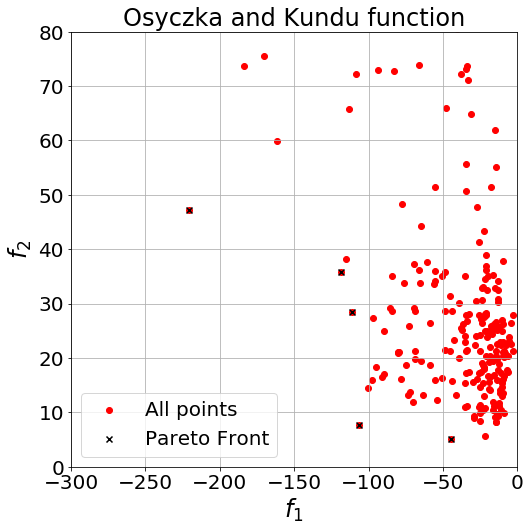

In [10]:
import matplotlib.pyplot as plt

C_clip = np.copy(C_step)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_step[C_clip==0.0,:])

fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='lower left',fontsize=20)
plt.xlim((-300, 0))
plt.ylim((   0,80))

plt.grid()

plt.title("Osyczka and Kundu function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Osyczka-Kundu.png",bbox_inches='tight')
plt.show()

In [11]:
np.savez('Osyczka-Kundu.npz',X_step=X_step,Y_step=Y_step,C_step=C_step)